In [1]:
kings <- scan("http://robjhyndman.com/tsdldata/misc/kings.dat",skip=3)


In [2]:
kings.ts<-ts(kings)

Este libro se encuentra en: https://media.readthedocs.org/pdf/a-little-book-of-r-for-time-series/latest/a-little-book-of-r-for-time-series.pdf

Las series se obtienen en: http://robjhyndman.com/TSDL/

In [3]:
births <- scan("http://robjhyndman.com/tsdldata/data/nybirths.dat")
births.ts <- ts(births, frequency=12, start=c(1946,1))


In [4]:
souvenir <- scan("http://robjhyndman.com/tsdldata/data/fancy.dat")
souvenir.ts<- ts(souvenir, frequency=12, start=c(1987,1))


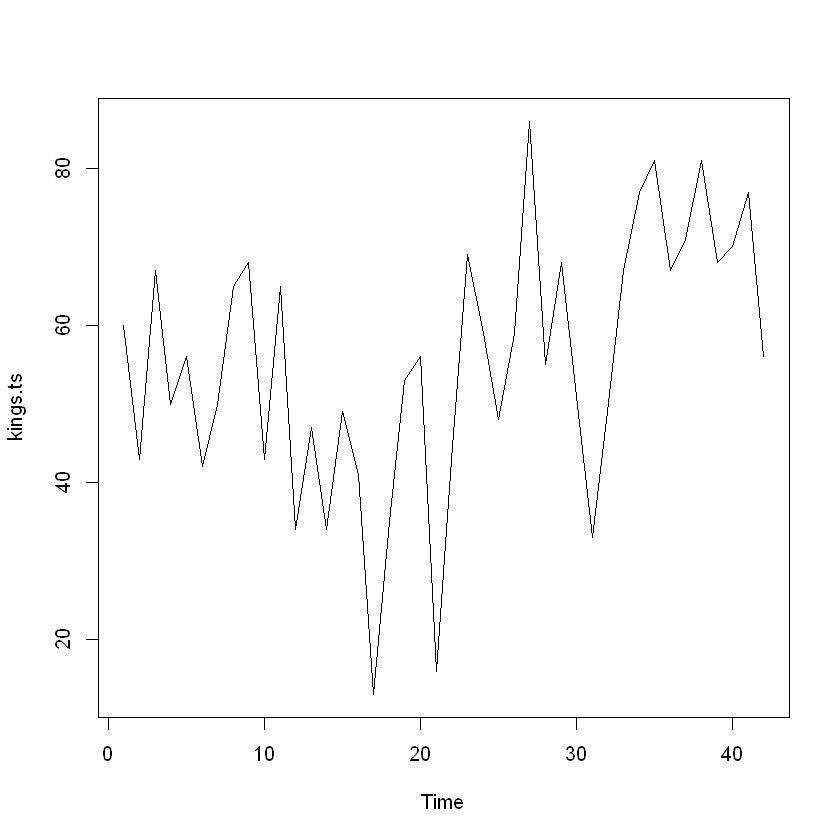

In [5]:
plot.ts(kings.ts)
#puede ser descrita usando un modelo aditivo porque las fluctuaciones aleatorias son constantes en el tiempo

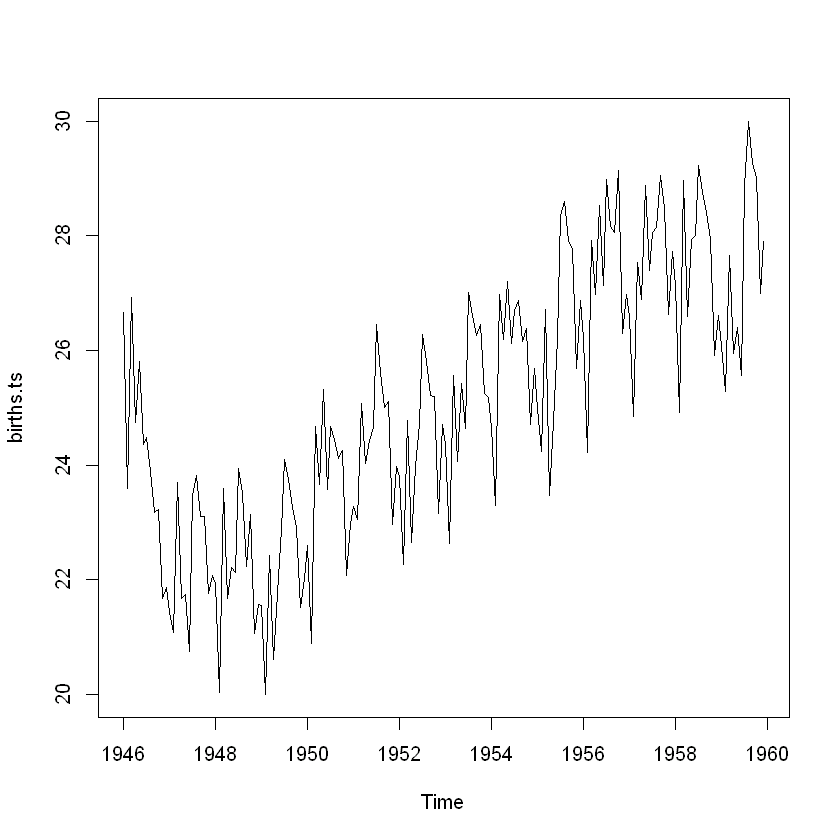

In [6]:
plot.ts(births.ts)

#Tiene una componente estacional, este comportamiento puede ser modelado.
#Como la fluctuacion temporal es constante en tamaño durante el tiempo, no parece tener un retono a un nivel

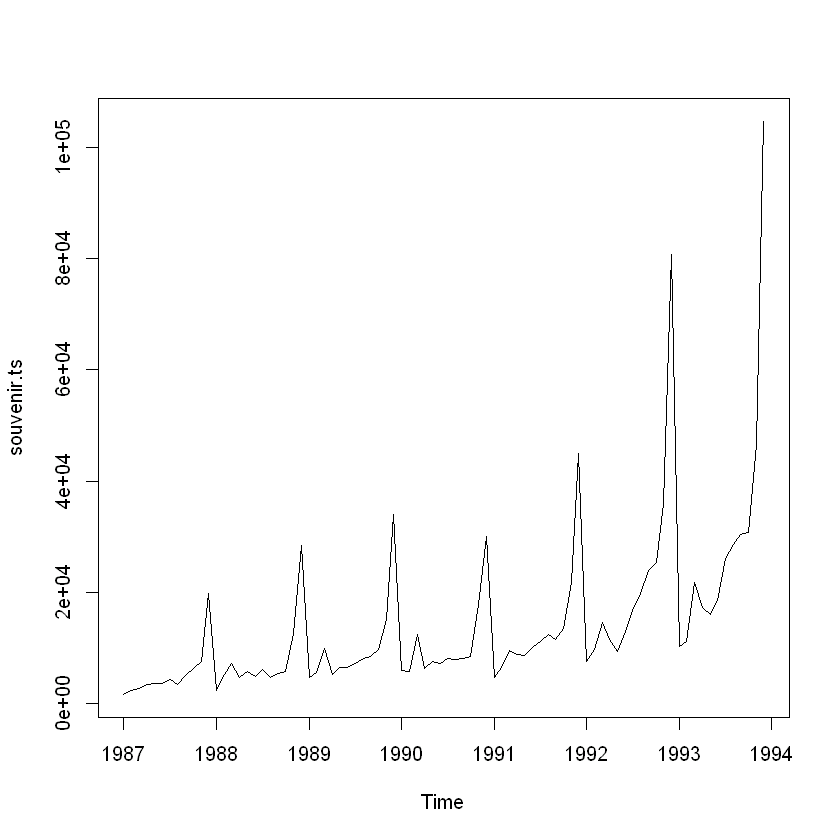

In [7]:
plot.ts(souvenir.ts)
#El modelo aditivo no parece ser adecuado porque las fluctuaciones crecen con el tiempo
#Entonces necesitamos transformar la serie para poder describir el comportamiento aditivo.
#por ejemplo con el logaritmo natural

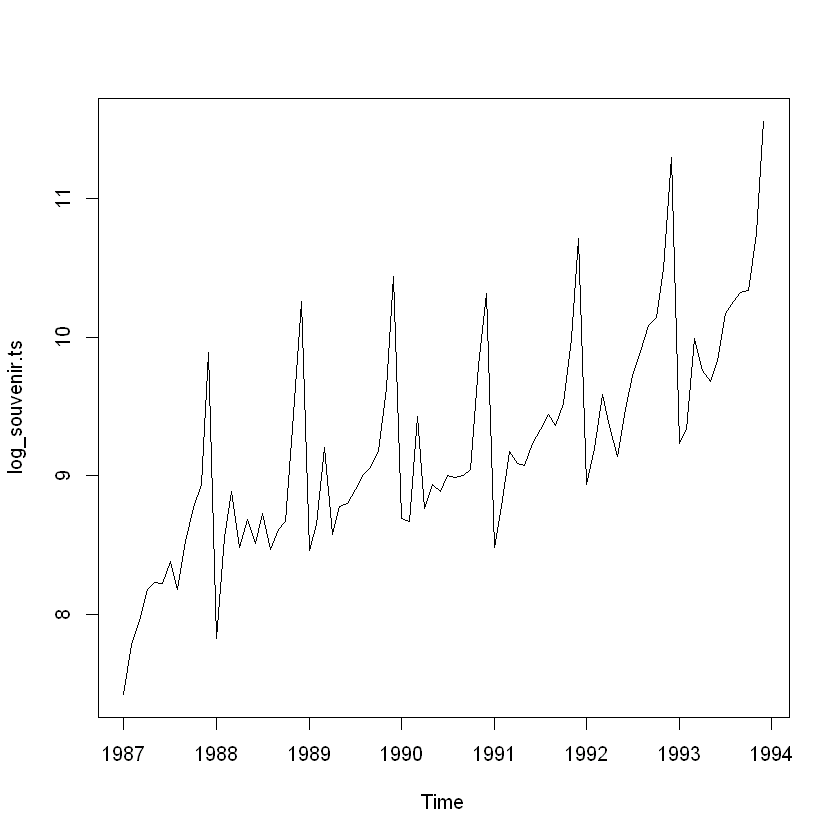

In [8]:
log_souvenir.ts<-log(souvenir.ts)
plot.ts(log_souvenir.ts)
#En este caso sse ve que las fluctuaciones son del mismo tamaño y con esto se dice que se pueden modelar la serie con un modelo aditivo

# Descomposicion de la serie de tiempo
Descomponer una serie de tiempos significa separar en sus componentes que la constituyen, las cuales son usualmente
1. Una tendencia
2. Una componente irregular
3. Una componente estacional (si existe)

## Descomposicion datos no estacionales
Consiste en las dos primeras componentes, descomponer es tratar de seperar la serie en estas dos componentes.

Para estimar la componente de tendencia es comun utilizar metodos de suavizacion como por ejemplo las medias moviles simples

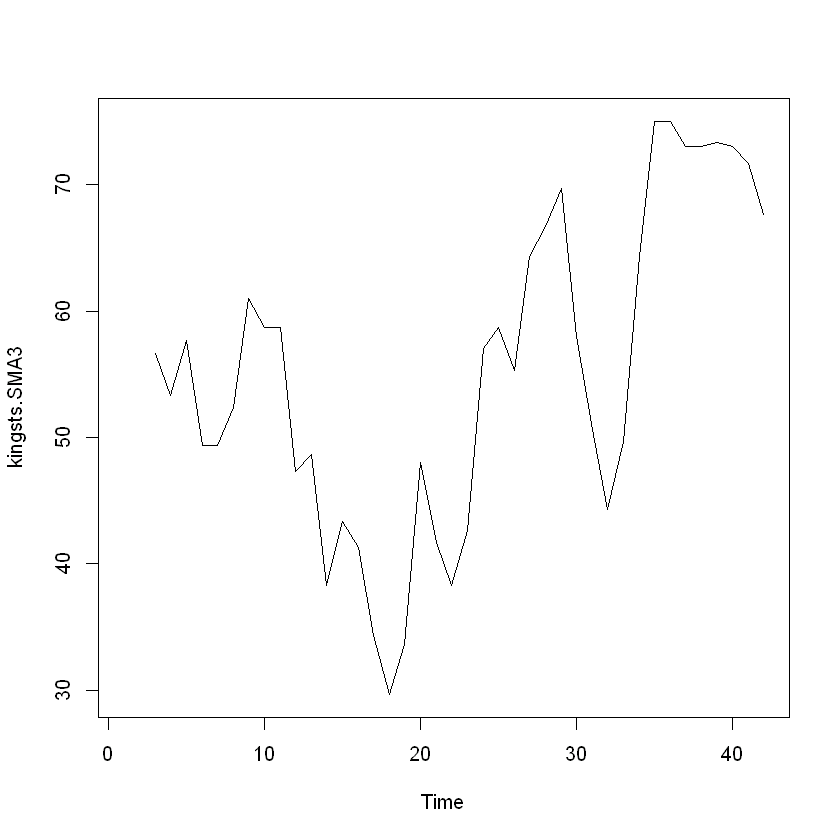

In [9]:
library(TTR)
#Comenzamos con un suavizado 3

kingsts.SMA3<-SMA(kings.ts,n = 3)
plot(kingsts.SMA3)

Al parecer todavia la serie no es lo suficientemente suavizada visto por la grafica, se procede a suavizar en ensayo-error para encontrar el mejor parametro de suavizado:

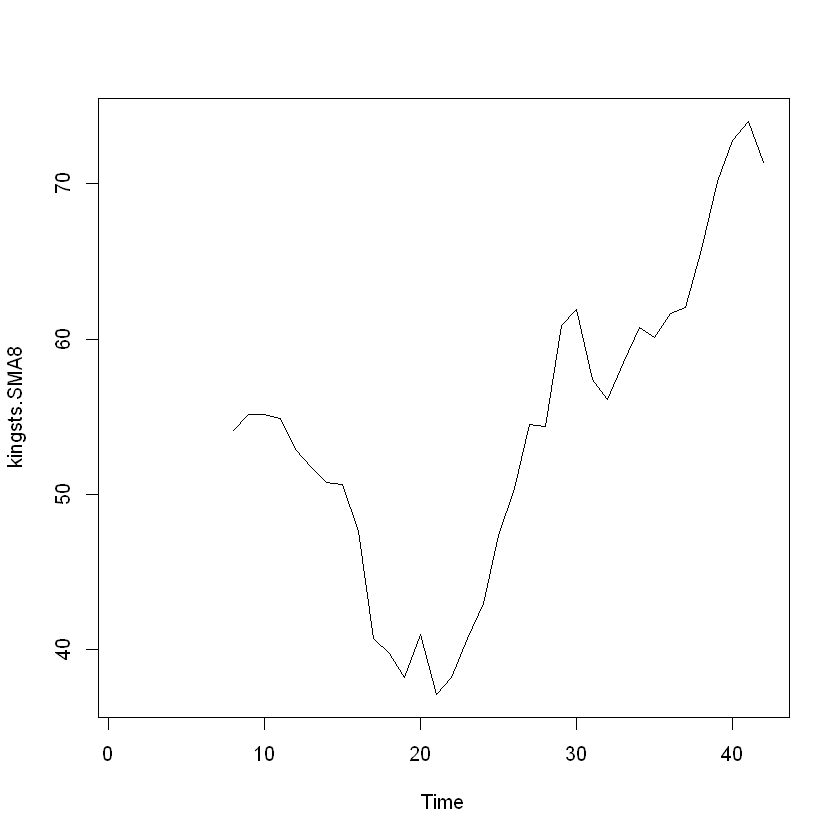

In [10]:
kingsts.SMA8<-SMA(kings.ts,n = 8)
plot.ts(kingsts.SMA8)
#El resultado es mejor y se puede observar la tendencia de la serie

## Descomposicion de datos estacionales

Consiste en separar:
1. La Tendencia
2. La componente estacional
3. La componente irregular

**Para estimar la tendencia**
Se utiliza la funcion de R $descompose()$ Esta funcion estima la componente de Tendencia, Estacionalidad y la componente irregular que describe el modelo aditivo.

Los objetivos que retorna la funcion son:

* seasonal
* trend
* random

In [11]:
birthsts.components<-decompose(births.ts)

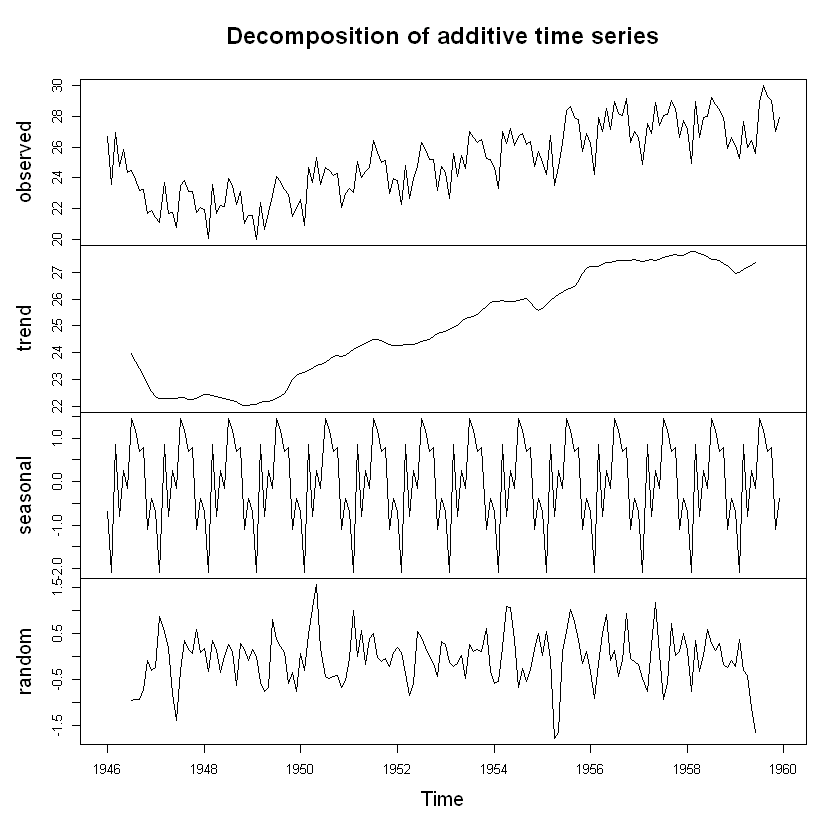

In [12]:
#Se pueden imprimir las componentes
plot(birthsts.components)

# Ajustes estacionales de la serie
Si se tiene una serie estacional que puede ser descrita con un modelo aditivo, se puede ajustar la serie calculando la componente estacional y extrayendola de la serie.

Esto se puede hacer con la funcion decompose()

Veamos un ejemplo con la serie de nacimientos:

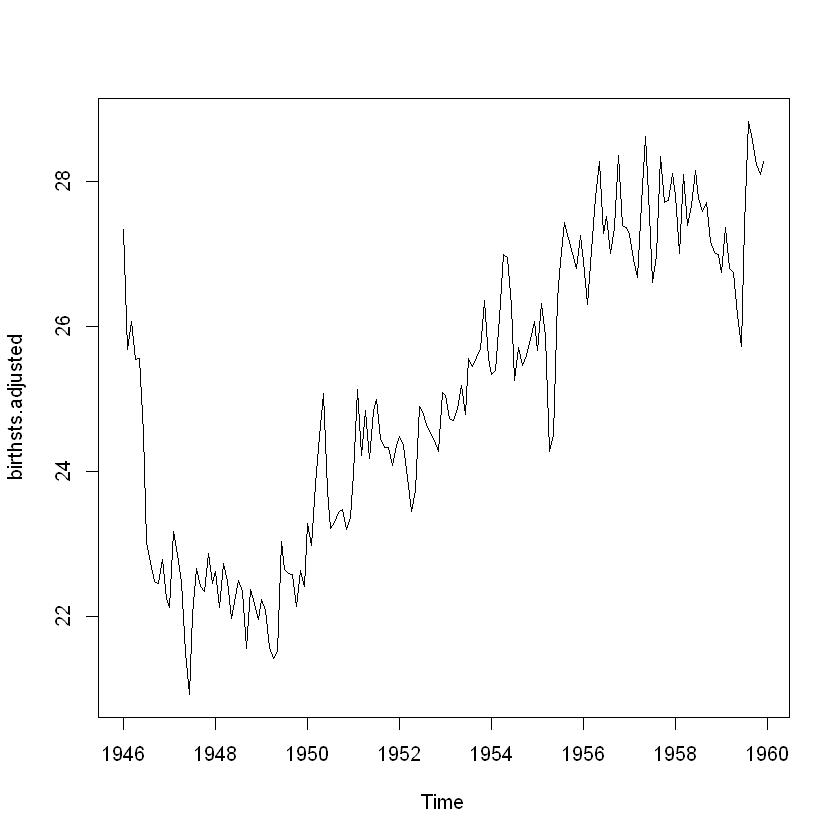

In [13]:
#Se utiliza decompose() para la serie, ya realizado
birthsts.adjusted<-births.ts-birthsts.components$seasonal #se remueve la estacionalidad de la serie
plot(birthsts.adjusted) #Se puede observar que la nueva serie solo contiene la componente tendencia e irregular

## Pronostico utilizando suavizado exponencial

Si se tiene una serie que puede ser descrita con un modelo aditivo, con un nivel constante y no estacional, se puede usar suavizado exponencial para hacer pronosticos de corto plazo

### Suavizado exponencial simple
Si se tiene una serie que puede ser descrita con un modelo aditivo con un nivel constante y no estacional, se puede usar suavizado exponencial simple para hacer pronostico

El suavizado exponencial simple provee una forma de estimar el nivel en tiempo actual.

El suavizado es gobernado por el parametro $\alpha$ para el estimador del nivel actual. 

Valores de $\alpha$ cercanos a cero significa que las observaciones recientes no  tienen mucho peso para el pronostico futuro

Ejemplo

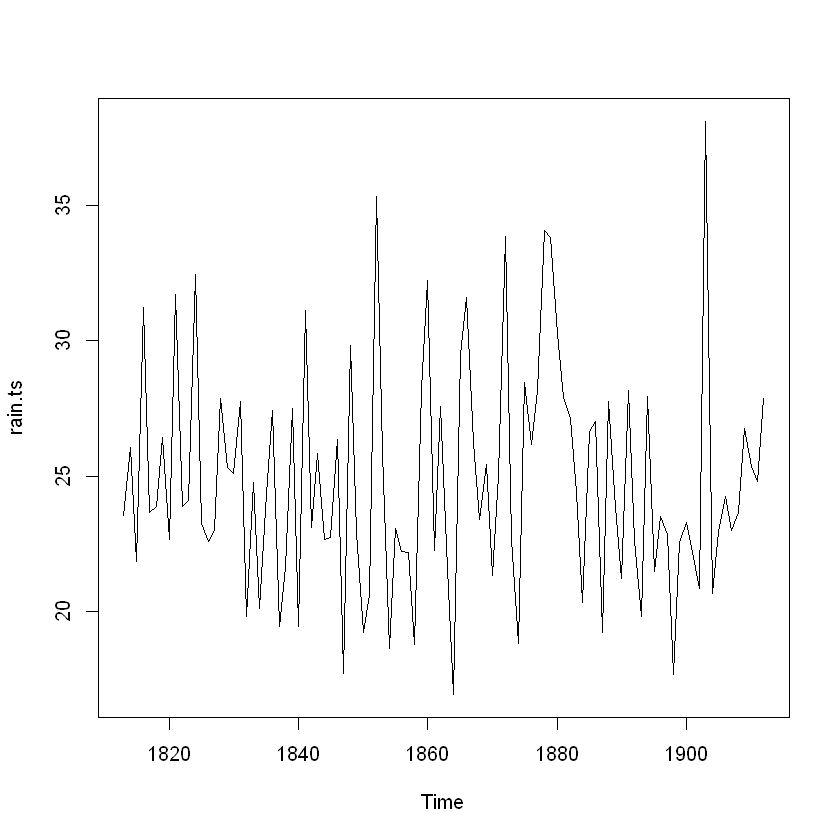

In [14]:
rain <- scan("http://robjhyndman.com/tsdldata/hurst/precip1.dat",skip=1)
rain.ts <- ts(rain,start=c(1813))
plot.ts(rain.ts)

Se puede observar que las variaciones no crecen en el tiempo y que giran alrededor una media, por esto se puede usar un modelo aditivo. Por lo tanto, la mejor forma de hacer pronostico es con un suavizado exponencial simple

Se utiliza la funcion **HoltWinters($\alpha=xx, \beta=NULL, \gamma=NULL$)**

La funcion retorna una serie de variables de la estimacion realizada.

Veamos un ejemplo con la serie de lluvias

In [21]:
raints.for<-HoltWinters(rain.ts,beta = FALSE,gamma = FALSE)
raints.for

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = rain.ts, beta = FALSE, gamma = FALSE)

Smoothing parameters:
 alpha: 0.02412151
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 24.67819

El retorno de la funcion nos dice que el valor estimado de $\alpha$ es 0.024, esto es muy cercano a cero, esto nos dice que los pronosticos estan basados en ambos, las obervaciones recientes y antiguas aunque algo más pesadas en las observaciones actuales.
Por defecto, la funcion pronostica dentro del mismo periodo de tiempo de la serie.

El pronostico se guarda en la variable **$fitted$**

plot(raints.for)

El grafico muestra la serie original en negro y el pronostico en rojo. La serie de tiempo de pronostico es mucho más suavizada que la original.

Podemos calcular el SSE como medida de precision para el pronostico

In [24]:
raints.for$SSE
head(rain.ts,n = 1)

[1] 1828.855

[1] 23.56

Es comun en suavizado exponencial simple usar la primera observacion como el valor inicial para el nivel de la serie. En este caso es 23.56.

In [26]:
HoltWinters(rain.ts,beta = FALSE,gamma = FALSE,l.start = 23.56)

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = rain.ts, beta = FALSE, gamma = FALSE, l.start = 23.56)

Smoothing parameters:
 alpha: 0.02412151
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 24.67819

Como se dijo en la funcion HoltWinters() solo se puede hacer pronostico dentro de la misma serie de tiempo, pero existe la funcion forecast.HoltWinters(). Se debe pasar la funcion ya suavizada con HoltWinters y el numero de periodos hacia adelante

In [34]:
library(forecast)
raints.for2<-forecast.HoltWinters(raints.for,h = 8)
raints.for2

     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1913       24.67819 19.17493 30.18145 16.26169 33.09470
1914       24.67819 19.17333 30.18305 16.25924 33.09715
1915       24.67819 19.17173 30.18465 16.25679 33.09960
1916       24.67819 19.17013 30.18625 16.25434 33.10204
1917       24.67819 19.16853 30.18785 16.25190 33.10449
1918       24.67819 19.16694 30.18945 16.24945 33.10694
1919       24.67819 19.16534 30.19105 16.24701 33.10938
1920       24.67819 19.16374 30.19265 16.24456 33.11182

Para imprimir el grafico del pronostico, se debe utilizar plot.forecast()

Time Series:
Start = 1813 
End = 1912 
Frequency = 1 
  [1]         NA  2.5100000 -1.7605450  7.6619220 -0.1128951  0.1198281
  [7]  2.6469377 -1.1569105  7.8909960 -0.1293468  0.1237733  8.4407877
 [13] -0.9328169 -1.6003159 -1.1317139  3.7755848  1.1245120  0.8573870
 [19]  3.5167056 -4.5081227  0.5606200 -4.1129030  0.2063065  3.2813300
 [25] -4.7778206 -2.4725723  3.4470698 -4.6960787  7.1171978 -1.0944797
 [31]  1.6919208 -1.5488909 -1.4115293  2.2325189 -6.4813328  5.7850067
 [37] -1.2345364 -4.9147575 -3.3862062 11.4054742  1.6803570 -5.6001757
 [43] -1.0550911 -1.8796407 -1.8643009 -5.2293312  4.3368082  8.2621979
 [49] -1.9070988  3.4389033 -2.6240483 -7.2207523  5.5034232  7.4906723
 [55]  1.9599860 -0.9372918  1.1053171 -3.0213449  0.7515345  9.5734064
 [61] -1.8475186 -5.6529537  4.1034041  1.7244238  3.6928281  9.5137515
 [67]  9.0242655  5.2665866  2.7795486  1.9325016 -0.8541132 -4.8835107
 [73]  1.5242869  1.8575188 -5.9872873  2.6871351 -1.2676827 -3.8571042
 [79]  3.1

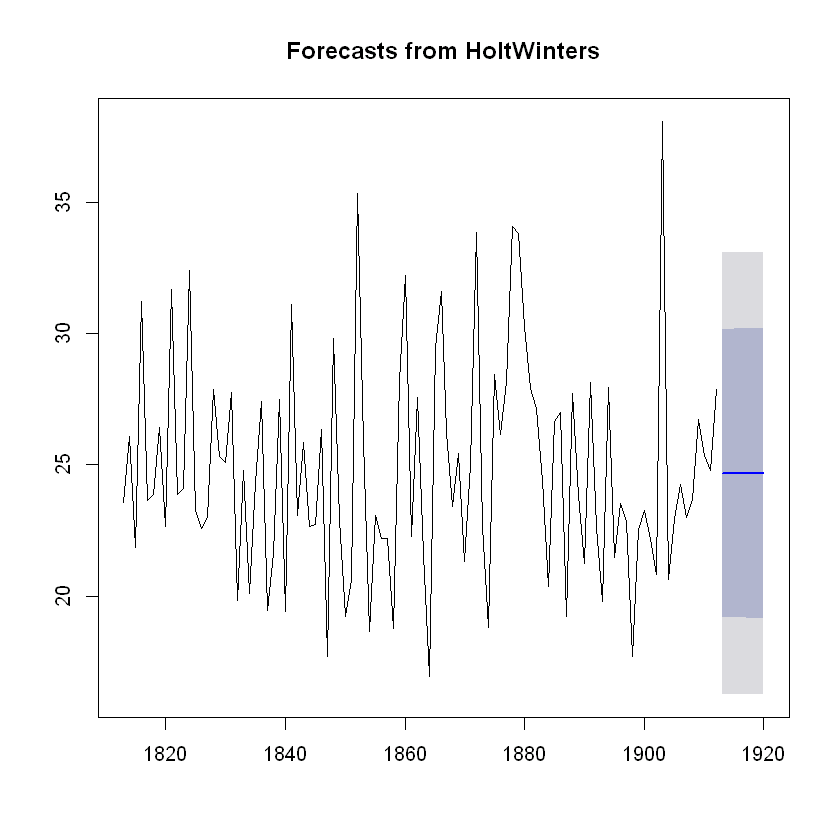

In [56]:
plot.forecast(raints.for2)
raints.for2$residuals

Para conocer si el suavizado exponencial simple puede ser mejorado por otro modelo, se imprime el ACF de los errores

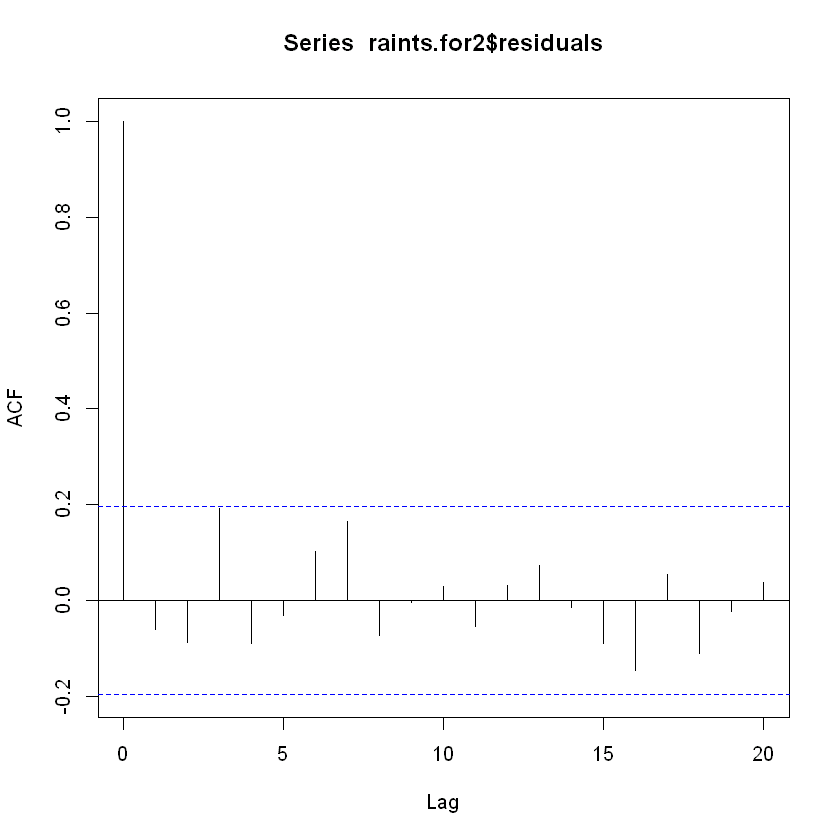

In [40]:
acf(raints.for2$residuals,lag.max = 20,na.action = na.pass)

Se observa que el retardo 3 casi toca las bandas de confianza. Para probar si hay evidencia significativa para los primeros 20 retardos, se usa la prueba de Ljung-Box. En R es $Box.test()$

In [41]:
Box.test(raints.for2$residuals,lag = 20, type = "Ljung-Box")


	Box-Ljung test

data:  raints.for2$residuals
X-squared = 17.401, df = 20, p-value = 0.6268


Como el Valor_p es menor que $\alpha$ se rechaza $H_0$ Hay poca evidencia de que los datos sean incorrelacionados. Pero asegurar que el modelo no puede ser mejorado, se debe verificar que los errores se distribuyen normalmente. Para porbar si los errores tienen varianza constante, imprimimos la serie de los errores:

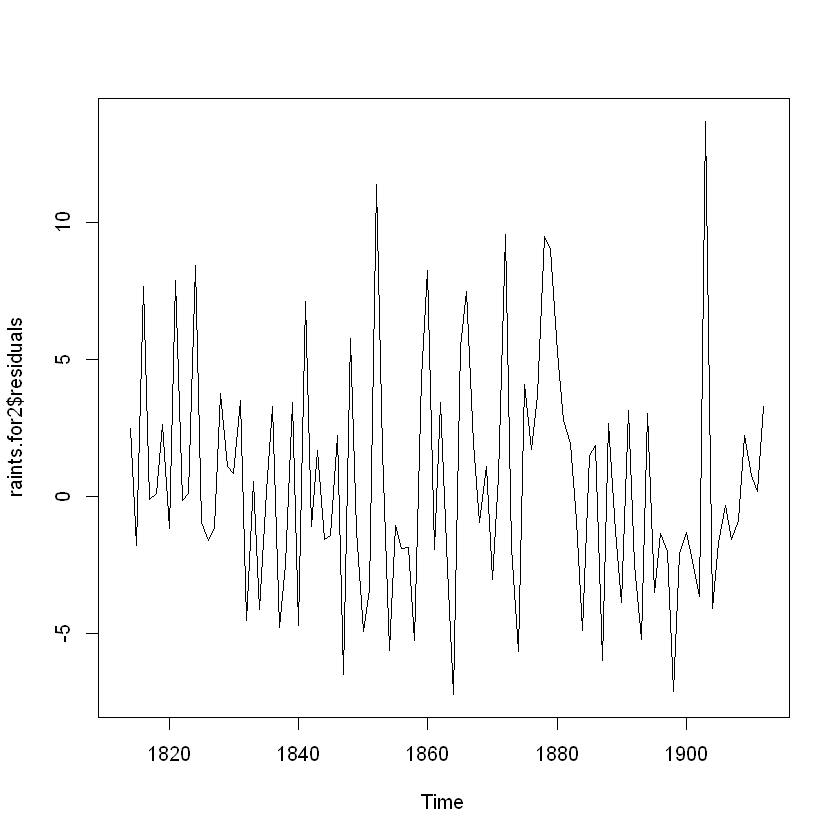

In [42]:
plot.ts(raints.for2$residuals)

El grafico muestra que el pronostico de la muestra tiene varianza constante, aunque los primeros datos tienen menos varianza que los demas datos. Pero de todas formas construimos un histograma para verificar que se distribuyan normalmente

In [45]:
plotForecastErrors<- function(forecasterrors){
    #construye el histograma de los errores
    mybinsize<-IQR(forecasterrors/4)
    mysd<-sd(forecasterrors)
    mymin<-min(forecasterrors)-mysd*5
    mymax<-max(forecasterrors)+mysd*3
    #Generar datos normales con media 0 y desviacion mysd
    mynorm<-rnorm(100000,mean = 0,sd=mysd)
    mymin2<-min(mynorm)
    mymax2<-max(mynorm)
    
    if (mymin2<mymin){mymin<-mymin2}
    if(mymax2>mymax){mymax<-mymax2}
    
    #imprime el histograma en rojo
    mybins<-seq(mymin,mymax,mybinsize)
    hist(forecasterrors,col="red",freq = FALSE,breaks = mybins)
    
    #freq=FALSE asegura que el area bajo la curva es 1
    
    #para generar datos normales con media 0 y desviacion mysd)
    
    myhist<-hist(mynorm,plot=FALSE,breaks=mybins)
    
    #imprime la curva normal sobre el histograma
    
    points(myhist$mids,myhist$density,type = "l", col="blue",lwd=2)
    
    }

La prueba de Ljung-Box muestra que hay poca evidencia de correlaciones que no son cero  y el grafico casi normal, indican que la serie de lluvia fue bien modelada

## Suavizado exponencial Holt

Si se tiene una serie de tiempo que puede ser descrita bajo un modelo aditivo con un tendencia creciente o decreciente y sin estacionalidad, se puede usar un suavizado exponencial de Holt para hacer pronostico de corto plazo.

Este suavizado exponencial de Holt estima el nivel y la pendiente en el tiempo actual. $\alpha$ es para el nivel y $\beta$ para la pendiente de la tendencia 

Veamos un ejemplo con el diametro de las faldas desde 1866 hasta 1911

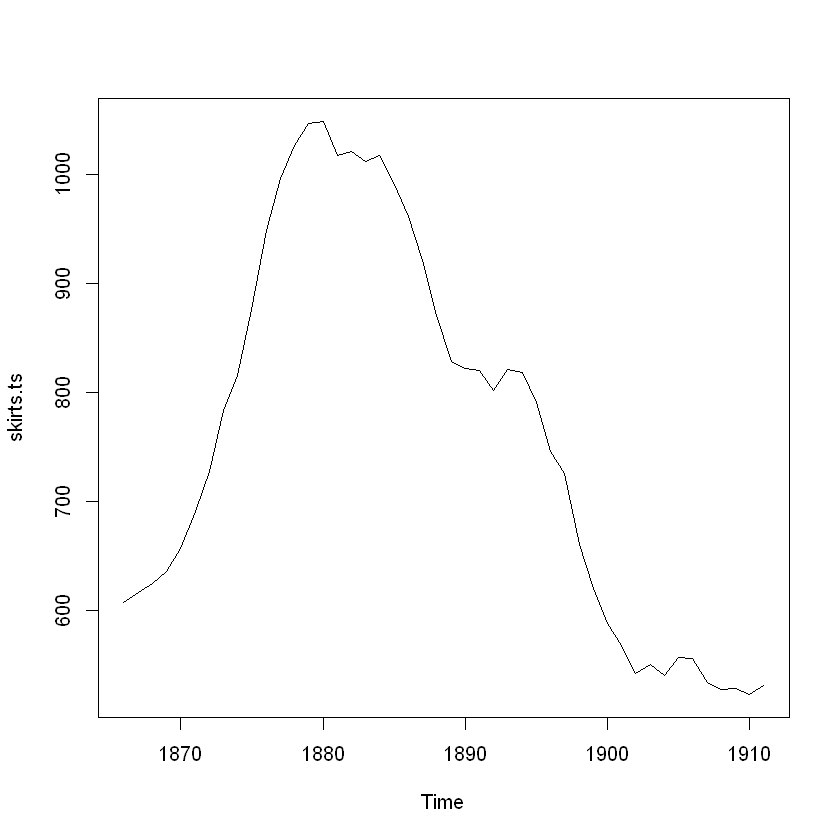

In [58]:
skirts <- scan("http://robjhyndman.com/tsdldata/roberts/skirts.dat",skip=5)
skirts.ts <- ts(skirts,start=c(1866))
plot.ts(skirts.ts)

In [61]:
skirtsseriesforecasts <- HoltWinters(skirts.ts, gamma=FALSE)
skirtsseriesforecasts

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = skirts.ts, gamma = FALSE)

Smoothing parameters:
 alpha: 0.8383481
 beta : 1
 gamma: FALSE

Coefficients:
        [,1]
a 529.308585
b   5.690464

$\alpha$ dio 0.84 y $\beta$ fue 1. Ambas dieron un numero alto lo que nos dice que estan basados en datos recientes

In [62]:
skirtsseriesforecasts$SSE

[1] 16954.18

El SSE nos da 16954

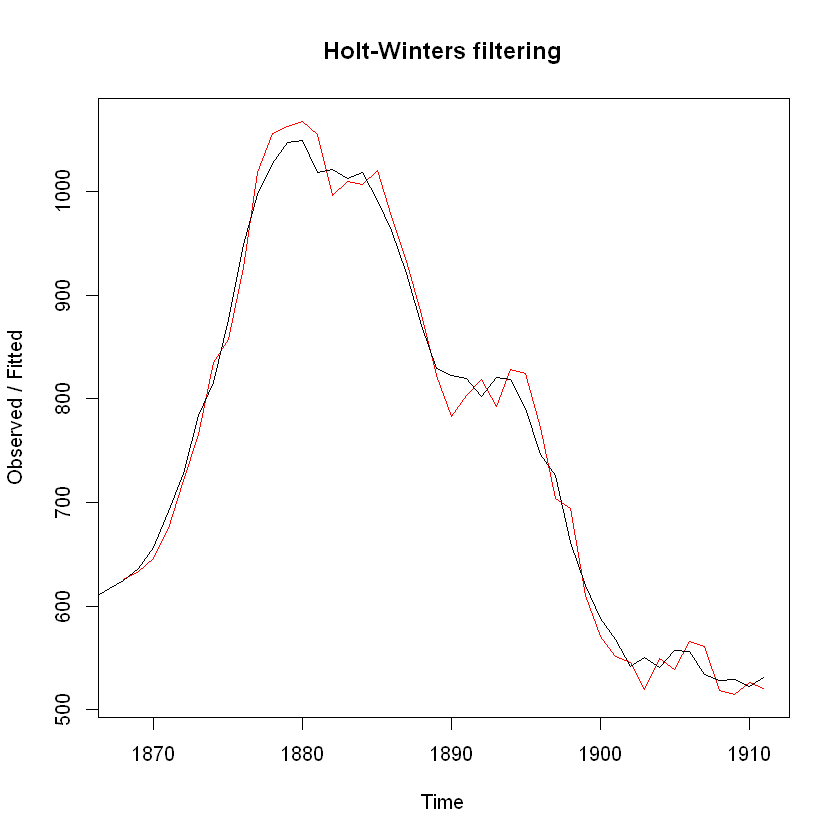

In [64]:
plot(skirtsseriesforecasts)

En el grafico se pueden observar la linea negra que es la serie original y los datos pronosticados dentro de la muestra

Tambien se pueden fijar los parametros iniciales del nivel y la pendiente como se presenta a continuacion con los siguientes argumentos de la funcion. La pendiente es la diferencia entre los dos primeros datos:



In [66]:
HoltWinters(skirts.ts, gamma=FALSE, l.start=608, b.start=9)


Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = skirts.ts, gamma = FALSE, l.start = 608, b.start = 9)

Smoothing parameters:
 alpha: 0.8346775
 beta : 1
 gamma: FALSE

Coefficients:
        [,1]
a 529.278637
b   5.670129

Tambien se puede pronosticar la serie como en el Suavizado simple HoltWinter con el paquete forecast

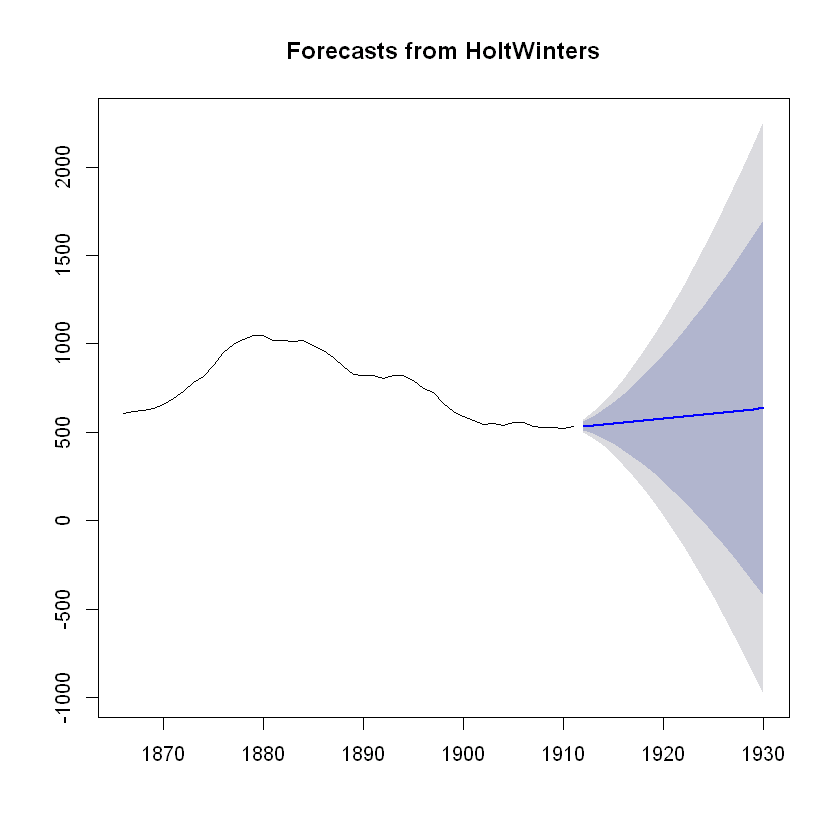

In [68]:
skirtsseriesforecasts2 <- forecast.HoltWinters(skirtsseriesforecasts, h=19)
plot.forecast(skirtsseriesforecasts2)



	Box-Ljung test

data:  skirtsseriesforecasts2$residuals
X-squared = 19.731, df = 20, p-value = 0.4749


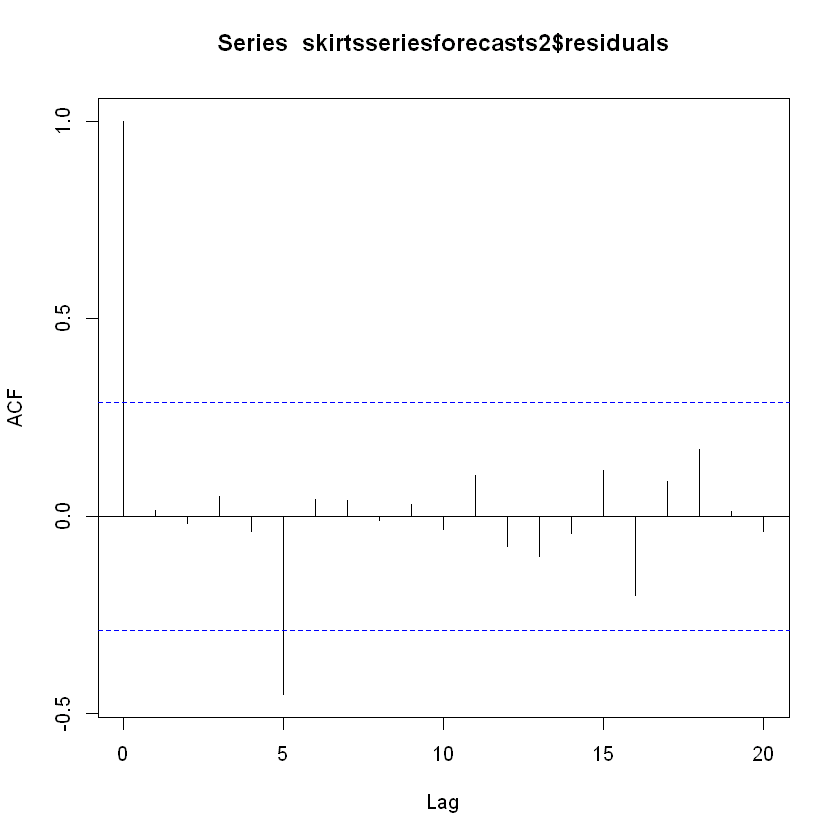

In [75]:
acf(skirtsseriesforecasts2$residuals,lag.max = 20, na.action = na.pass)
Box.test(skirtsseriesforecasts2$residuals,lag=20,type = "Ljung-Box")

El ACF muestra un dato atipico en la serie, sin embargo con la prueba de autocorrelacion de los errores se puede comprobar que para la serie este dato no es significativo

A continuacion probamos que los errores sean constantes en media y varianza y que estan normalmente distribuidos alrededor de 0

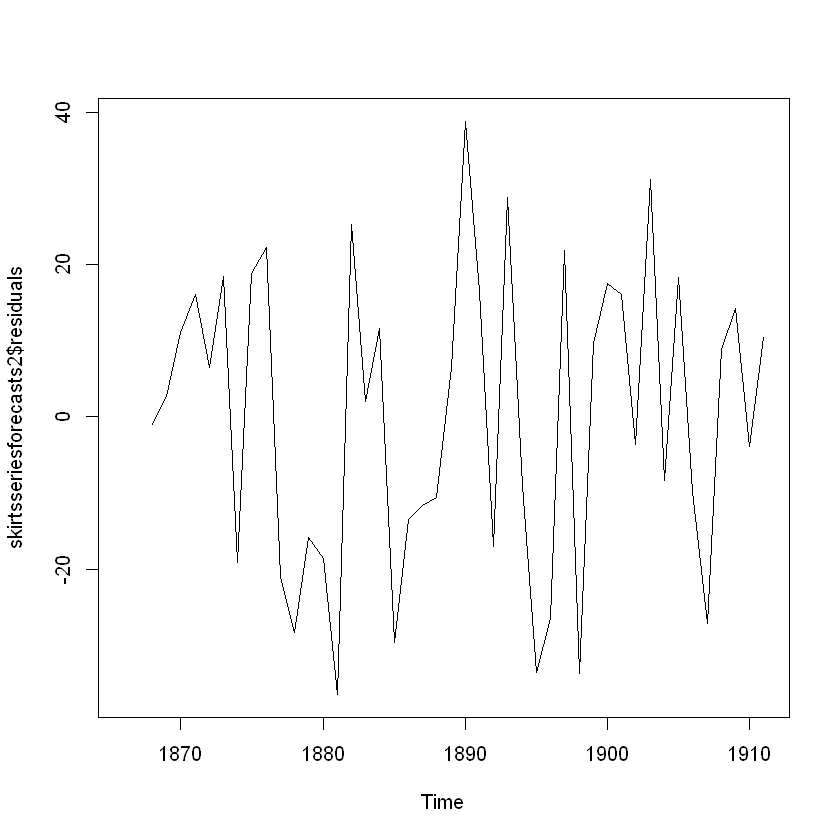

In [80]:
plot.ts(skirtsseriesforecasts2$residuals)

## Suavizado Exponencial HoltWinters

Si se tiene una serie que puede ser descrita usando un modelo aditivo con tendencia creciente y estacionalida, se puede usar el modelo de Suavizado Exponencial HoltWinters para pronostico de corto plazo

Este modelo estima el nivel($\alpha$),la pendiente($\beta$) y la componente estacional ($\gamma$)

A continuacion presentamos un ejemplo de los log de las ventas mensuales de una tienda de playa en Australia.



In [84]:
logsouvenirtimeseries <- log(souvenir.ts)
souvenirtimeseriesforecasts <- HoltWinters(logsouvenirtimeseries)
souvenirtimeseriesforecasts

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = logsouvenirtimeseries)

Smoothing parameters:
 alpha: 0.413418
 beta : 0
 gamma: 0.9561275

Coefficients:
           [,1]
a   10.37661961
b    0.02996319
s1  -0.80952063
s2  -0.60576477
s3   0.01103238
s4  -0.24160551
s5  -0.35933517
s6  -0.18076683
s7   0.07788605
s8   0.10147055
s9   0.09649353
s10  0.05197826
s11  0.41793637
s12  1.18088423

$\alpha$ = 0.41, es bajo e indica que el nivel actual es estimado con la informacion actual e historica
$\beta$= 0, indica que la pendiente no se actualiza en el tiempo
$\gamma$=0.96, indica que la estacionalidad depende de los datos recientes




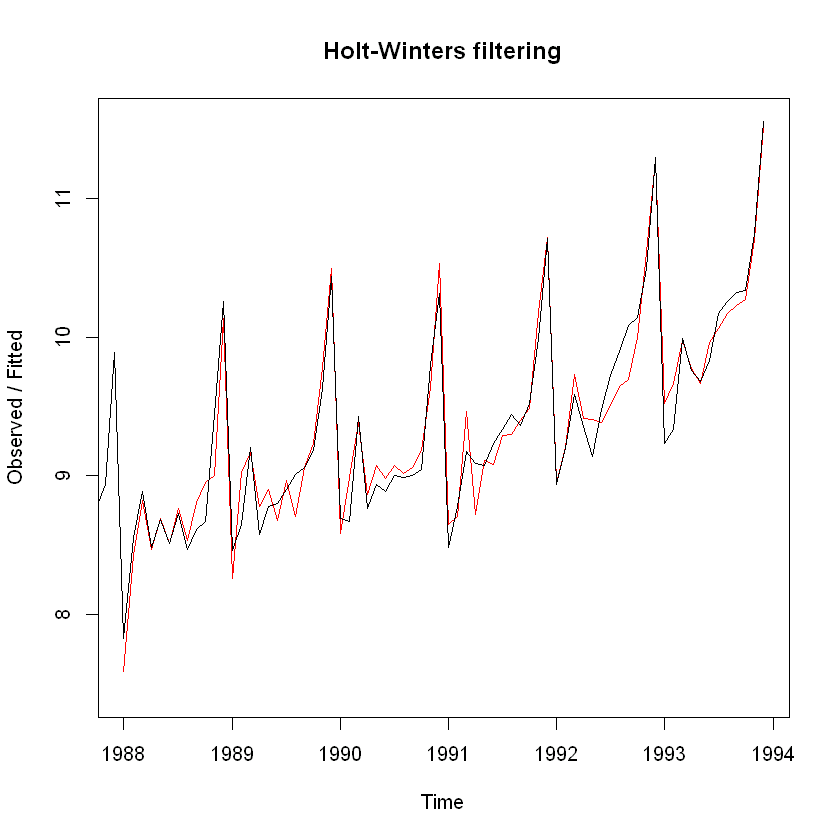

In [85]:
plot(souvenirtimeseriesforecasts)

El modelo es bueno para identificar los picos que ocurren en noviembre

Para los datos futuros se usa la funcion forecast

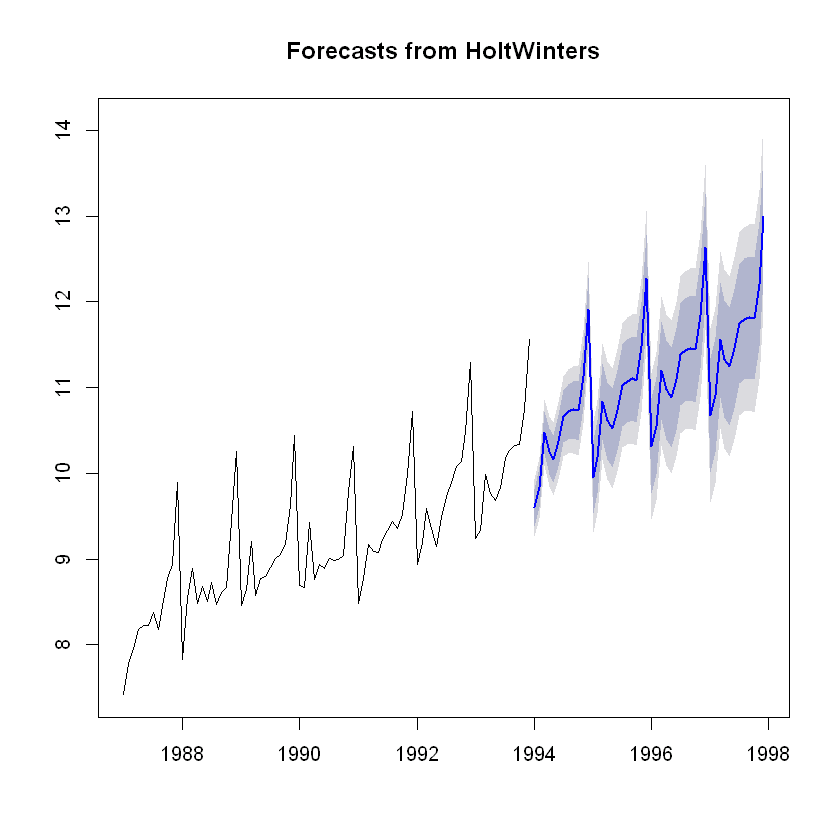

In [87]:
souvenirtimeseriesforecasts2<-forecast.HoltWinters(souvenirtimeseriesforecasts,h=48)
plot.forecast(souvenirtimeseriesforecasts2)

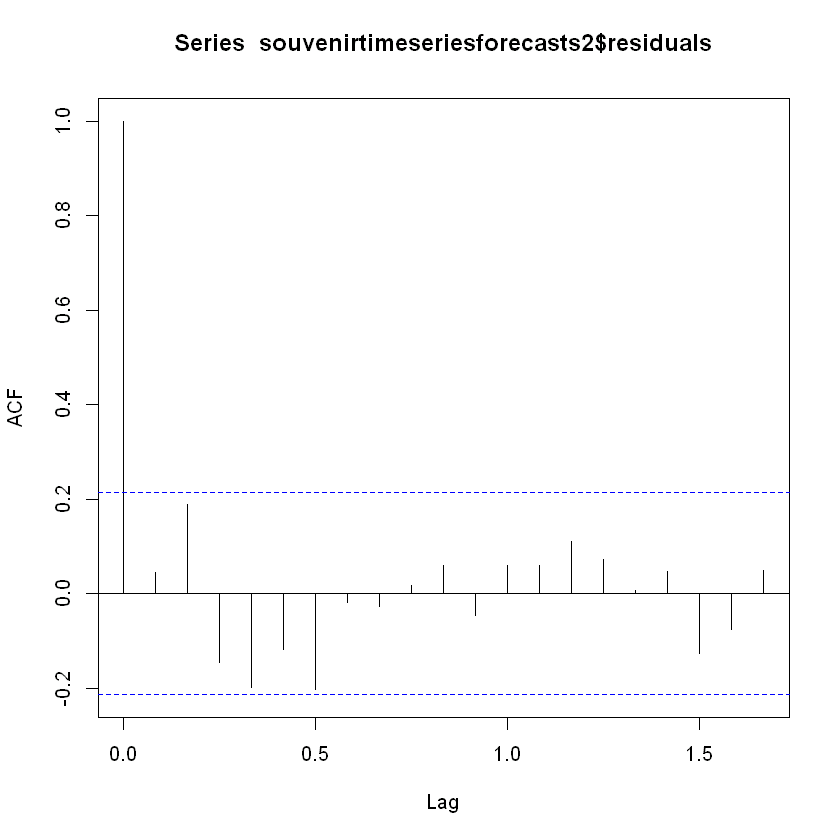

In [89]:
acf(souvenirtimeseriesforecasts2$residuals, lag.max=20,na.action = na.pass)

In [90]:
Box.test(souvenirtimeseriesforecasts2$residuals, lag=20, type="Ljung-Box")


	Box-Ljung test

data:  souvenirtimeseriesforecasts2$residuals
X-squared = 17.53, df = 20, p-value = 0.6183


# Modelos ARIMA

Los metodos de suavizado exponencial son utiles para hacer pronostico de series que no hacen supuestos entre los valores de la serie. De cualquier forma, si se desea establecer unos intervalos de prediccion, se requiere que los errores sean incorrelacionados y se distribuyan normales con media cero y varianza finita.

Mientras que los metodos exponenciales no tienen ningun supuesto sobre autocorrelacion de los rezagos, en algunos casos es mejor hacer modelos predictivos tomando la correlacion de los datos en cuenta. Los modelos ARIMA incluyen un modelo estadistico para la componente irregular que permite que autocorrelacion en la componente irregular

### Diferenciacion
Los modelos ARIMA deben ser estacionarios en media, por lo tanto si se tiene una serie no estacionaria se debe diferenciar hasta obtener una serie estacionaria. Por lo tanto $d$ sera el numero de veces que se diferencia la serie.

Veamos un ejemplo con los datos skirts

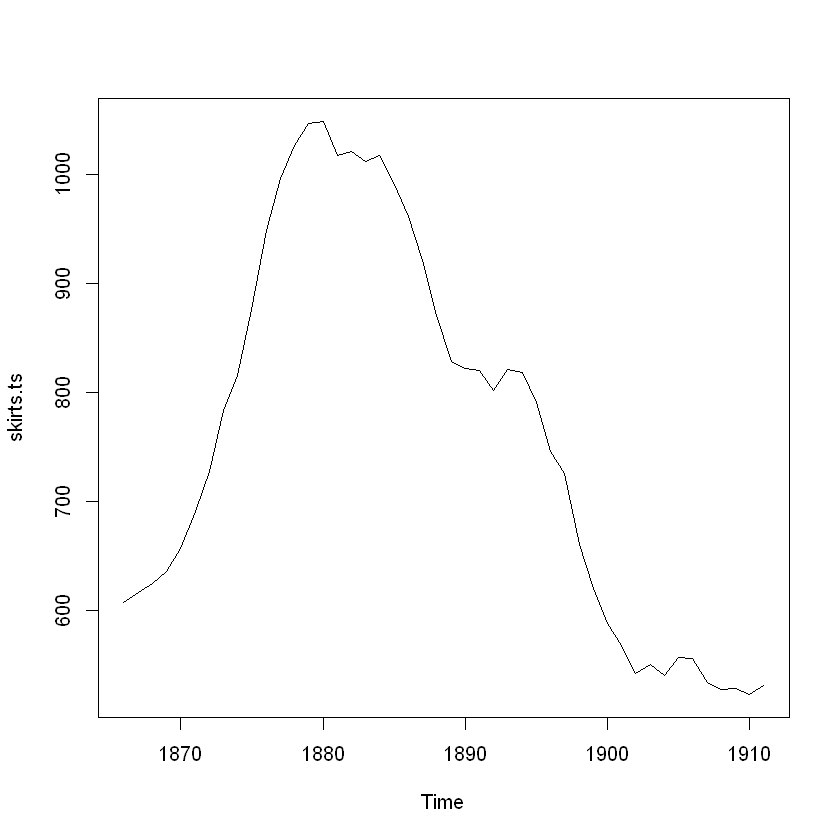

In [91]:
plot(skirts.ts)

Si se diferencia la serie anterior y se imprime se debe ver una nueva serie estacionaria en media

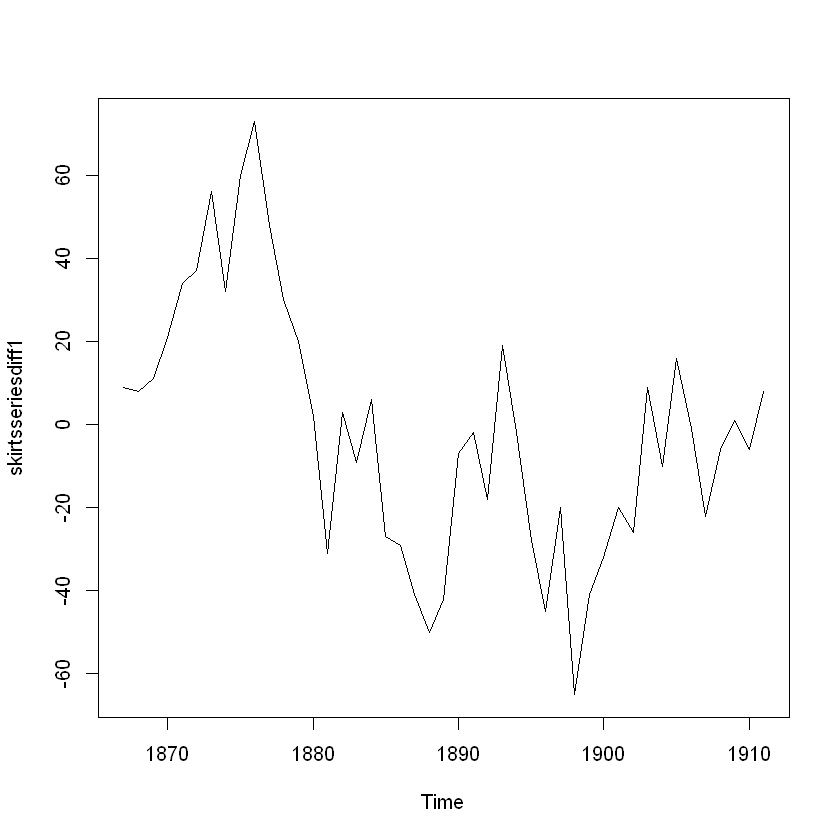

In [93]:
skirtsseriesdiff1<-diff(skirts.ts,differences = 1)
plot.ts(skirtsseriesdiff1)

La anterior grafica no se estacionaria a simple vista por lo que se procede a diferenciar la segunda vez:

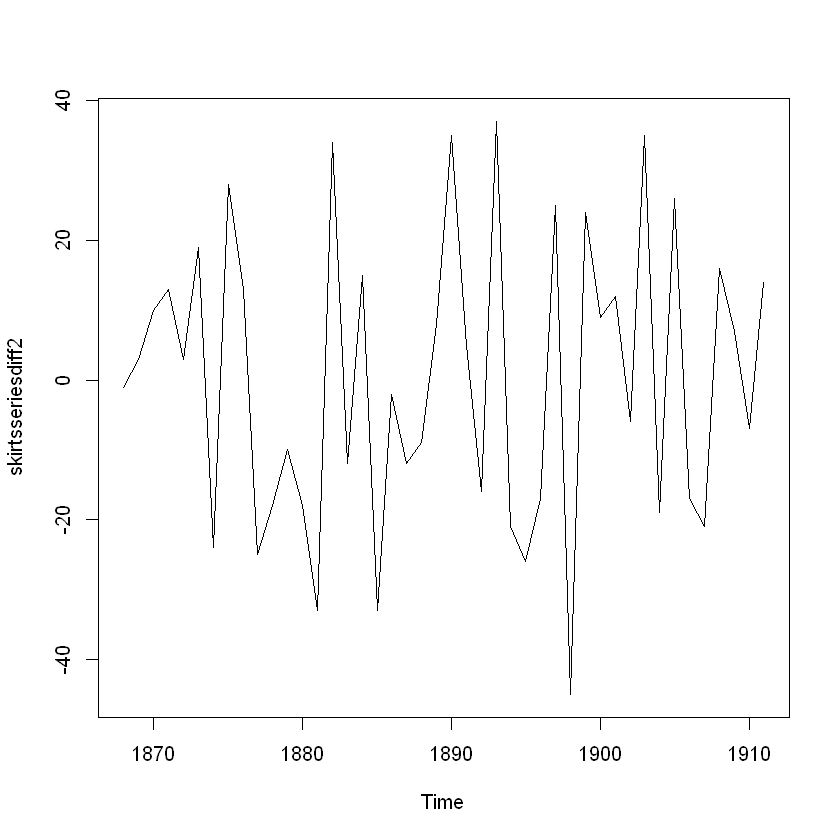

In [95]:
skirtsseriesdiff2<-diff(skirts.ts,differences = 2)
plot.ts(skirtsseriesdiff2)

### Prueba para saber si una serie es estacionaria
La prueba formal para estacionareidad es llamada **Prueba de raiz unitaria** disponible en la library(fUnitRoots) y es la prueba de Dickey Fuller.



Retomando el ejemplo anterior, la segunda diferenciacion parece ser estacionaria en media y en varianza

Otro ejemplo se puede ver con la serie de la edad de los reyes de Inglaterra


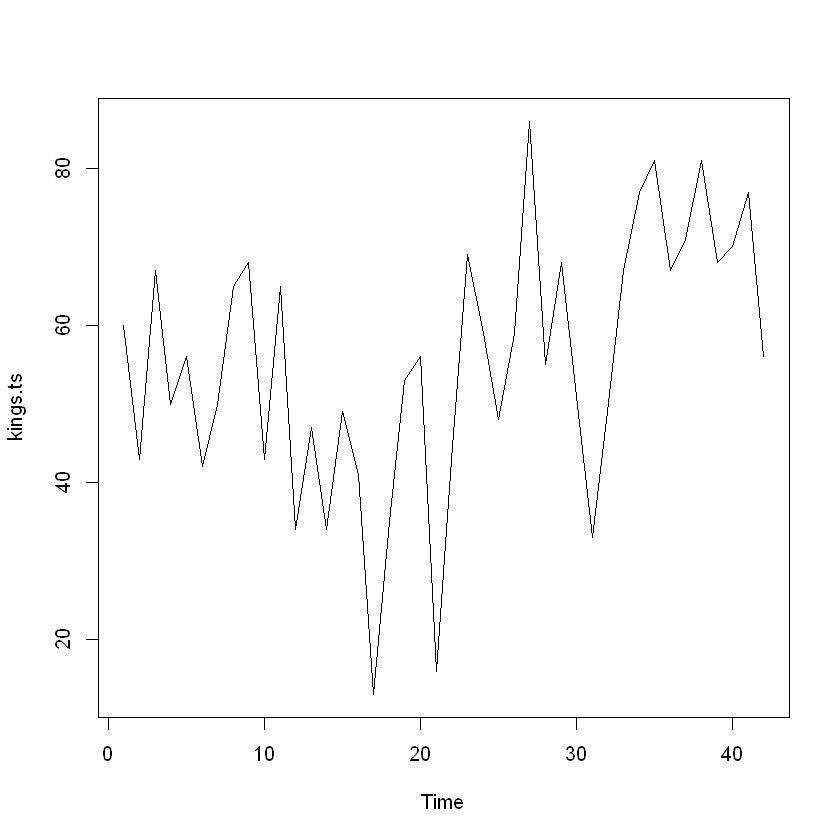

In [96]:
plot(kings.ts)

Graficamente podemos ver que la serie no es estacionaria en media, por lo que procedemos a diferenciar los datos:


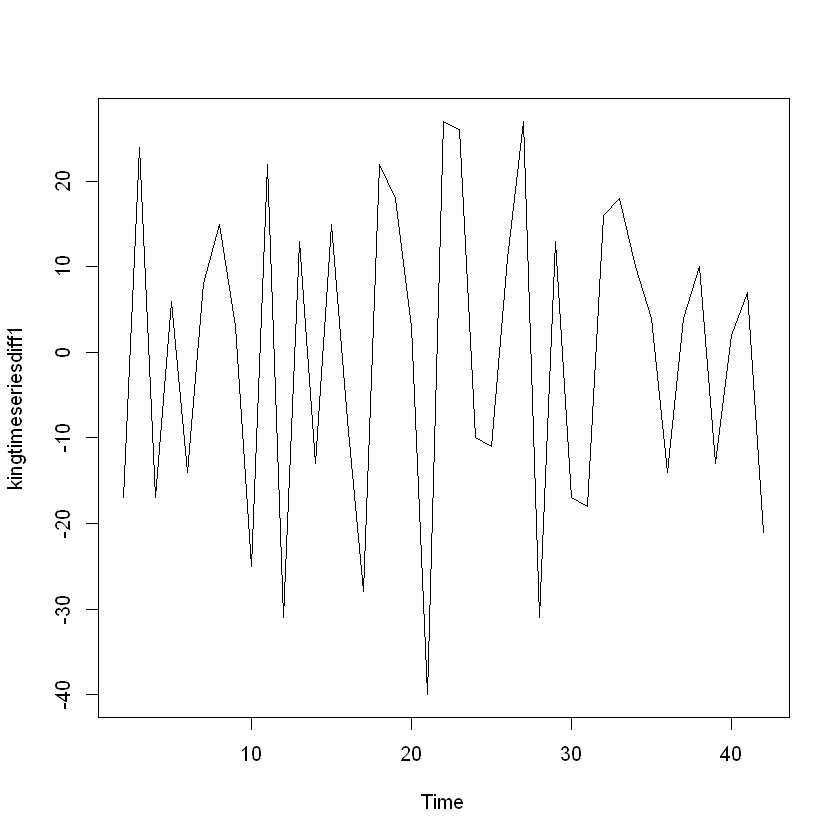

In [98]:
kingtimeseriesdiff1 <- diff(kings.ts, differences=1)
plot(kingtimeseriesdiff1)

Tomando la primera diferenciacion parece que podemos decir que es estacionaria en media. Cuando se hace diferenciacion, se dice que hemos removido la componente de Tendencia de la serie y solo nos queda la componente irregular  y con esto se puede evaluar si se tiene correlacion entre los terminos sucesivos de la componente irregular

## Seleccionar el mejor modelo ARIMA

Una vez se tenga una serie estacionaria en media, el siguiente paso es encontrar un modelo ARIMA que se ajuste a los datos. Para esto se usa el ACF y el PACF de la serie estacionaria

Miremos con la serie de la edad de los reyes los valores del ACF


Autocorrelations of series 'kingtimeseriesdiff1', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.360 -0.162 -0.050  0.227 -0.042 -0.181  0.095  0.064 -0.116 -0.071 
    11     12     13     14     15     16     17     18     19     20 
 0.206 -0.017 -0.212  0.130  0.114 -0.009 -0.192  0.072  0.113 -0.093 

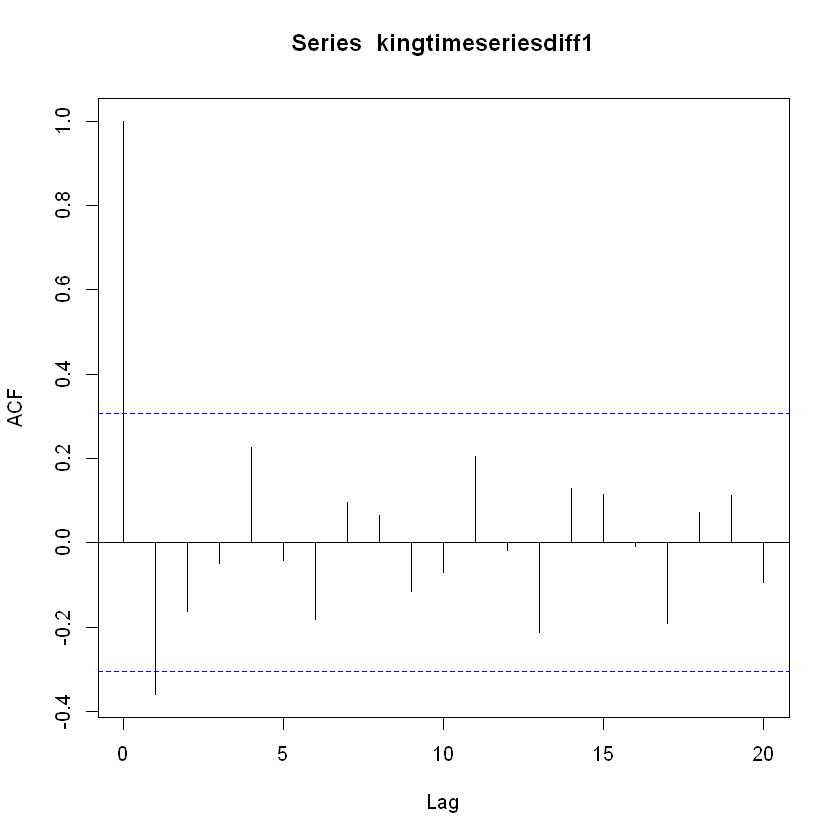

In [101]:
acf(kingtimeseriesdiff1,lag.max = 20)#imprime el ACF de la serie
acf(kingtimeseriesdiff1,lag.max=20, plot=F)#muestra los datos calculados

Luego se puede observar el PACF


Partial autocorrelations of series 'kingtimeseriesdiff1', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.360 -0.335 -0.321  0.005  0.025 -0.144 -0.022 -0.007 -0.143 -0.167  0.065 
    12     13     14     15     16     17     18     19     20 
 0.034 -0.161  0.036  0.066  0.081 -0.005 -0.027 -0.006 -0.037 

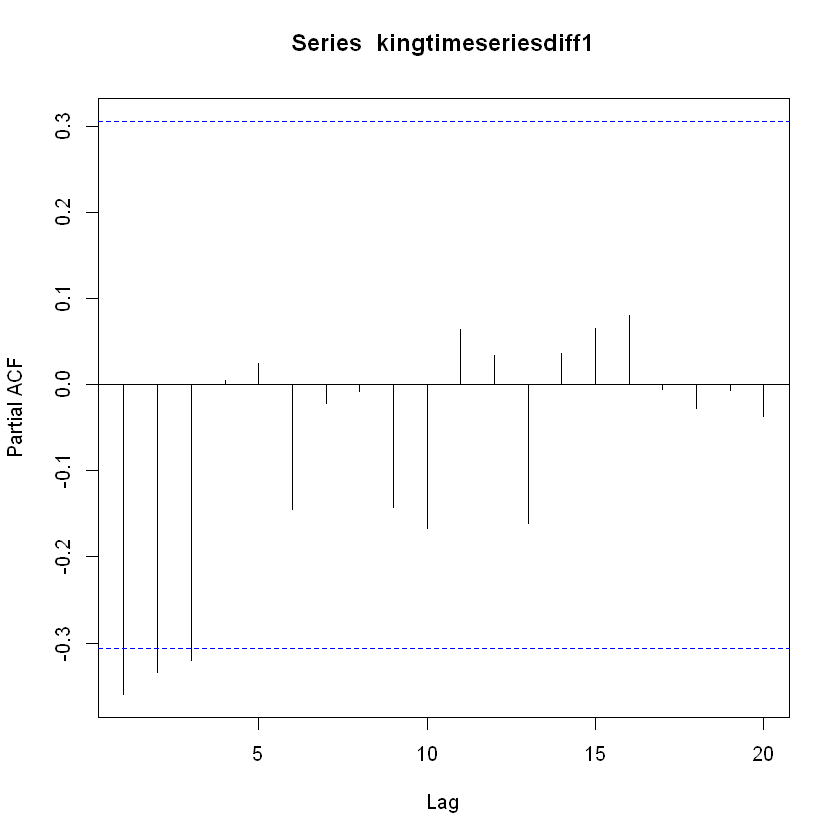

In [102]:
pacf(kingtimeseriesdiff1,lag.max = 20)#Imprime el PACF
pacf(kingtimeseriesdiff1,lag.max = 20, plot=F) #Muestra los datos calculados

Con el ACF que se convierte en cero despues del primer rezago
Con el PACF que se convierte en cero despues del tercer rezago, se puede decir que los posibles modelos son:

1. AR(3)
2. MA(1)
3. ARMA($p,q$) por definir

El primer criterio siempre sera el más parsimonioso, es decir el que menos parametros tenga, por lo anterior se supone que el MA(1) es el mejor modelo.

Un modelo MA es usualmente usado para modelar series de tiempo que muestran dependencia de corto plazo entre las observaciones. Intuituivamente, esto tiene sentido para la serie de edad de los reyes pues no tiene relacion la edad de muerte de un rey y otro.

Verifiquemos esto con la funcion auto.arima()

In [108]:
auto.arima(kings.ts)

Series: kings.ts 
ARIMA(0,1,1)                    

Coefficients:
          ma1
      -0.7218
s.e.   0.1208

sigma^2 estimated as 236.2:  log likelihood=-170.06
AIC=344.13   AICc=344.44   BIC=347.56

## Otro ejemplo
Con una serie de tiempo de humo volcanico desde 1500 hasta 1969

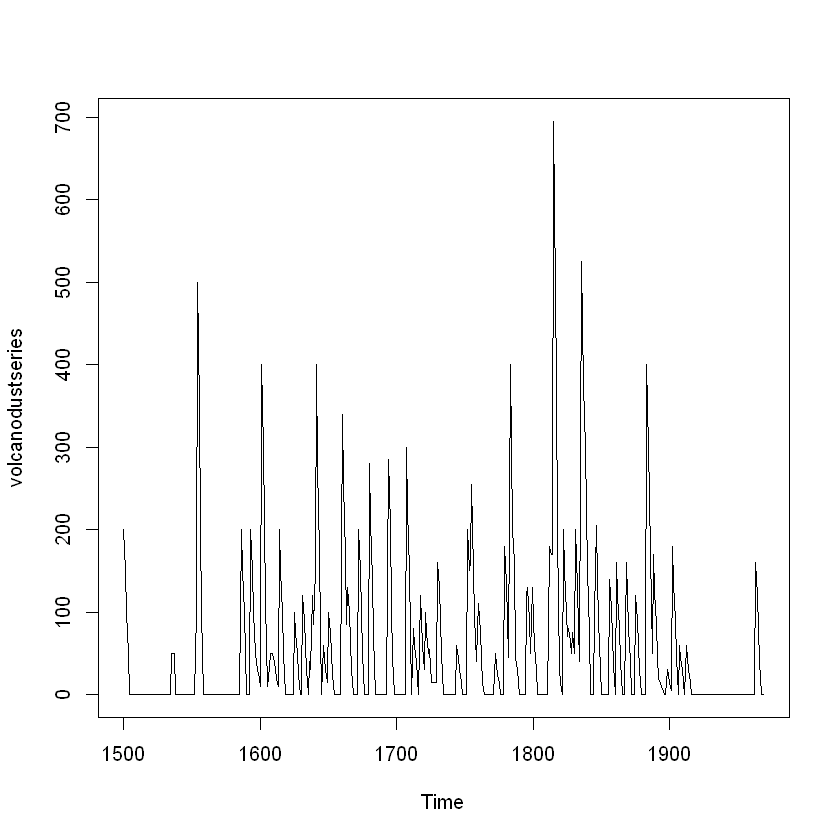

In [109]:
volcanodust <- scan("http://robjhyndman.com/tsdldata/annual/dvi.dat", skip=1)
volcanodustseries <- ts(volcanodust,start=c(1500))
plot.ts(volcanodustseries)

Desde el grafico se puede ver que las fluctuaciones aleatorias son aproximadamente constantes en el tiempo, por lo que se puede decir que un modelo aditivo puede modelar la serie. Ademas parace que la serie es estacionaria
Por lo que podemos proceder a ajustar un modelo ARIMA

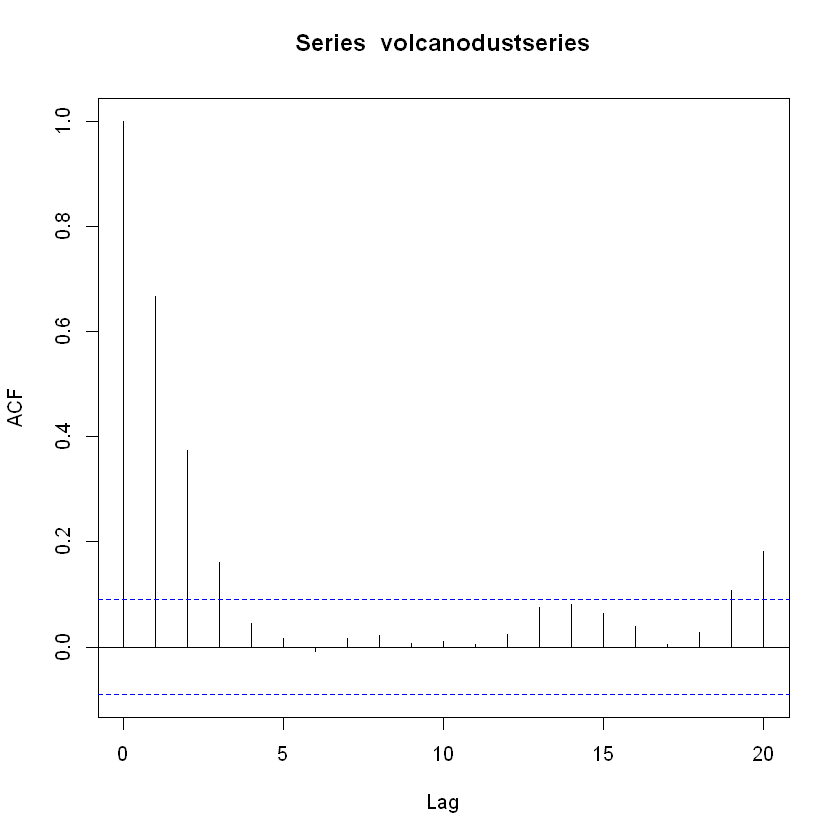

In [110]:
acf(volcanodustseries,lag.max = 20)


En el ACF() vemos que los primeros 3 rezagos son significativos y que los rezagos 19 y 20 tambien pero esto es probable que se deba a la casualidad y nosotros esperamos que 1 de 20 rezagos exceda el nivel de confianza.

Veamos el PACF()


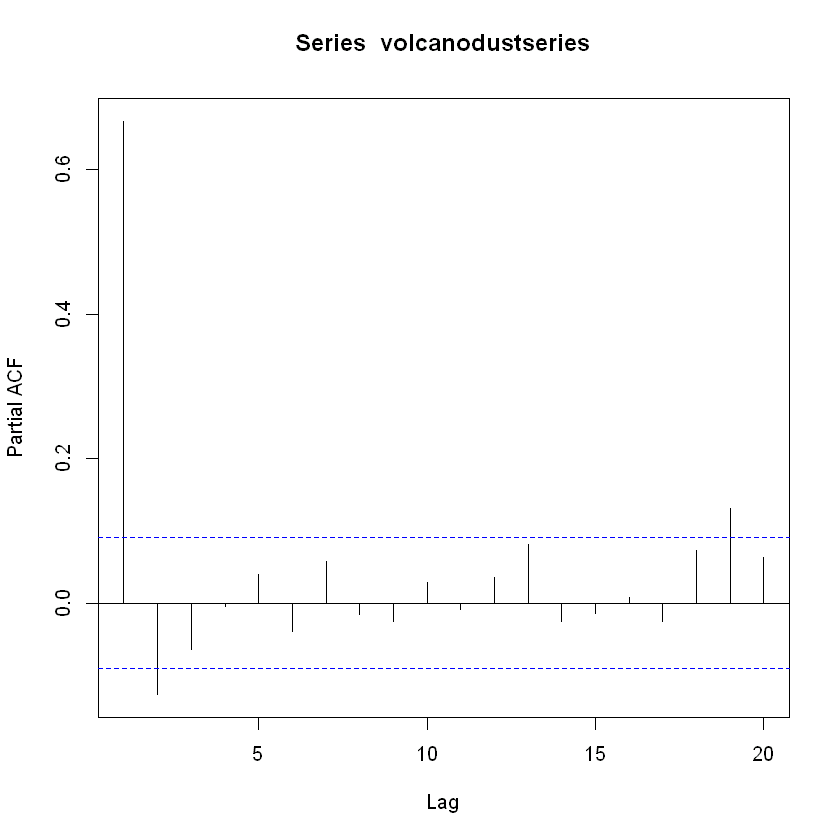

In [111]:
pacf(volcanodustseries,lag.max = 20)

De acuerdo con el ACF y el PACF, los posibles modelos son:

1. AR(2)
2. MA(3)
3. ARMA($p,q$)

En este caso el AR y el ARMA tienen el mismo numero de parametros-

El AR es usualmente usado para modelar una serie de tiempos la cual muestra más larga dependencia entre las observaciones. Intuitivamente, tiene sentido que un modelo AR podria ser usado para describir la serie de tiempo del polvo volcanico y que este se demora tiempo en desaparecer 

## Pronostico usando modelos ARIMA

Una vez se tiene el mejor modelo ARIMA para modelar la serie de datos, se estiman los parametros y se usa para pronosticar futuros valores de la serie

### Ejemplo con la edad de los reyes de Inglaterra


In [113]:
kingstimeseriesarima<-arima(kings.ts,order = c(0,1,1)) #Ajustamos el modelo ARIMA
kingstimeseriesarima


Call:
arima(x = kings.ts, order = c(0, 1, 1))

Coefficients:
          ma1
      -0.7218
s.e.   0.1208

sigma^2 estimated as 230.4:  log likelihood = -170.06,  aic = 344.13

Luego usamos la funcion forecast.ARIMA() para hacer los pronosticos. Si queremos aumentar el nivel de confianza del pronostico, utilizamos el argumento "level=c(99.5)"

In [114]:

kingstimeseriesforecasts<-forecast.Arima(kingstimeseriesarima,h=5)
kingstimeseriesforecasts

   Point Forecast    Lo 80    Hi 80    Lo 95     Hi 95
43       67.75063 48.29647 87.20479 37.99806  97.50319
44       67.75063 47.55748 87.94377 36.86788  98.63338
45       67.75063 46.84460 88.65665 35.77762  99.72363
46       67.75063 46.15524 89.34601 34.72333 100.77792
47       67.75063 45.48722 90.01404 33.70168 101.79958

Tambien podemos graficar el pronostico realizado con sus bandas de confianza

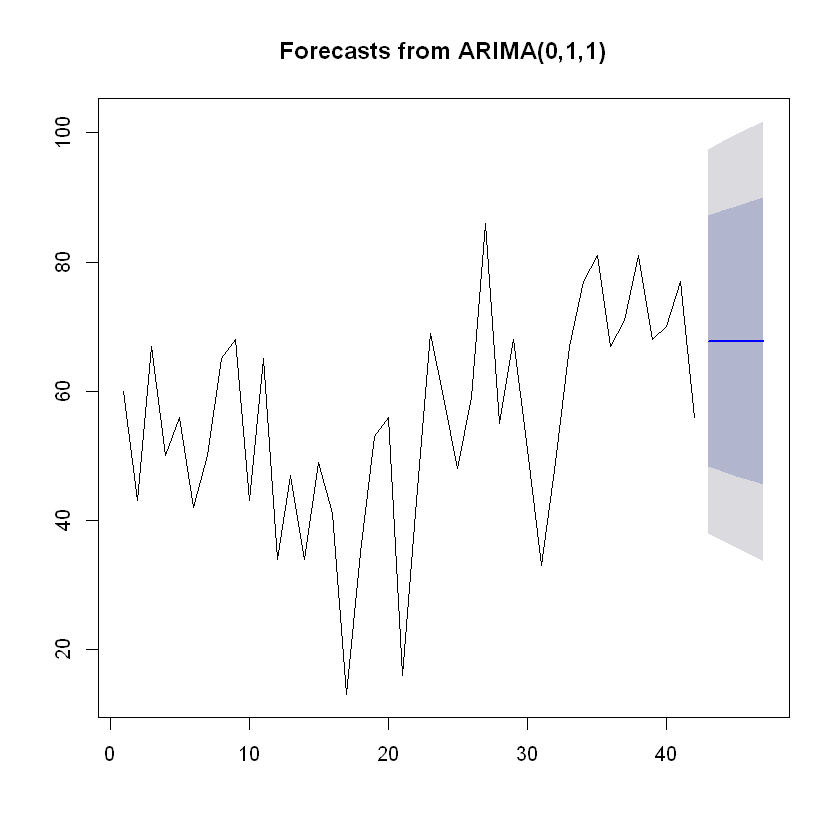

In [115]:
plot(kingstimeseriesforecasts)

Ahora verifiquemos que los errores sean incorrelacionados:


	Box-Ljung test

data:  kingstimeseriesforecasts$residuals
X-squared = 13.584, df = 20, p-value = 0.8509


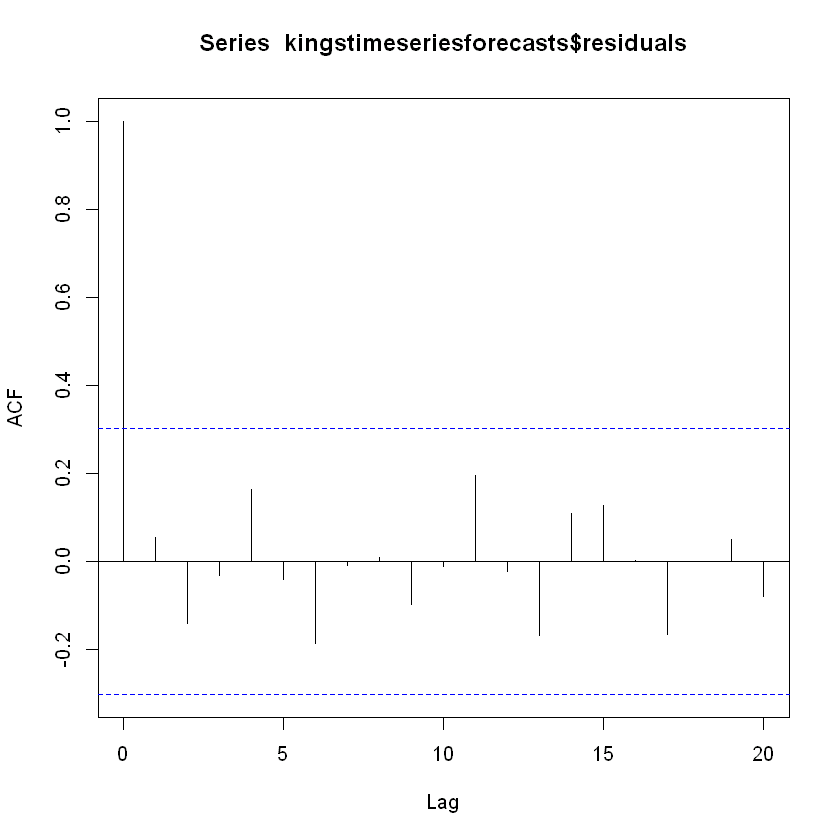

In [118]:
acf(kingstimeseriesforecasts$residuals,lag.max = 20)
Box.test(kingstimeseriesforecasts$residuals,lag = 20,type = "Ljung-Box")

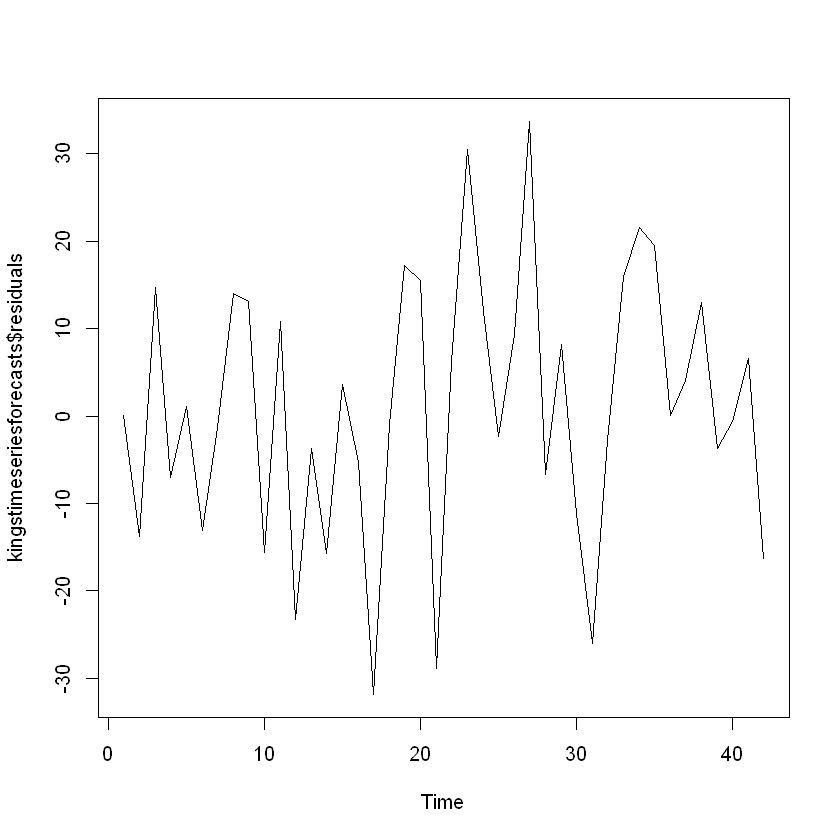

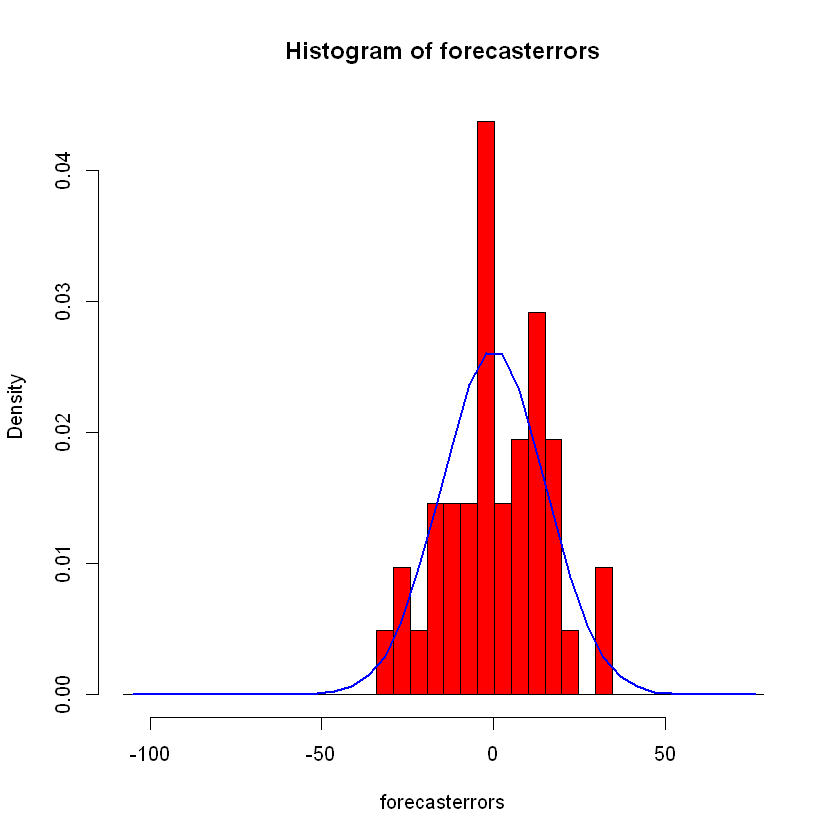

In [120]:
plot.ts(kingstimeseriesforecasts$residuals)
plotForecastErrors(kingstimeseriesforecasts$residuals)

## Ejemplo del polvo volcanico

In [121]:
volcanodustarima<-arima(volcanodustseries,order = c(2,0,0))
volcanodustarima


Call:
arima(x = volcanodustseries, order = c(2, 0, 0))

Coefficients:
         ar1      ar2  intercept
      0.7533  -0.1268    57.5274
s.e.  0.0457   0.0458     8.5958

sigma^2 estimated as 4870:  log likelihood = -2662.54,  aic = 5333.09

In [122]:
volcanodustforecast<-forecast.Arima(volcanodustarima,h = 31)
volcanodustforecast

     Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
1970       21.48131 -67.94860 110.9112 -115.2899 158.2526
1971       37.66419 -74.30305 149.6314 -133.5749 208.9033
1972       47.13261 -71.57070 165.8359 -134.4084 228.6737
1973       52.21432 -68.35951 172.7881 -132.1874 236.6161
1974       54.84241 -66.22681 175.9116 -130.3170 240.0018
1975       56.17814 -65.01872 177.3750 -129.1765 241.5327
1976       56.85128 -64.37798 178.0805 -128.5529 242.2554
1977       57.18907 -64.04834 178.4265 -128.2276 242.6057
1978       57.35822 -63.88124 178.5977 -128.0615 242.7780
1979       57.44283 -63.79714 178.6828 -127.9777 242.8634
1980       57.48513 -63.75497 178.7252 -127.9356 242.9059
1981       57.50627 -63.73386 178.7464 -127.9145 242.9271
1982       57.51684 -63.72330 178.7570 -127.9040 242.9376
1983       57.52212 -63.71802 178.7623 -127.8987 242.9429
1984       57.52476 -63.71538 178.7649 -127.8960 242.9456
1985       57.52607 -63.71407 178.7662 -127.8947 242.9469
1986       57.

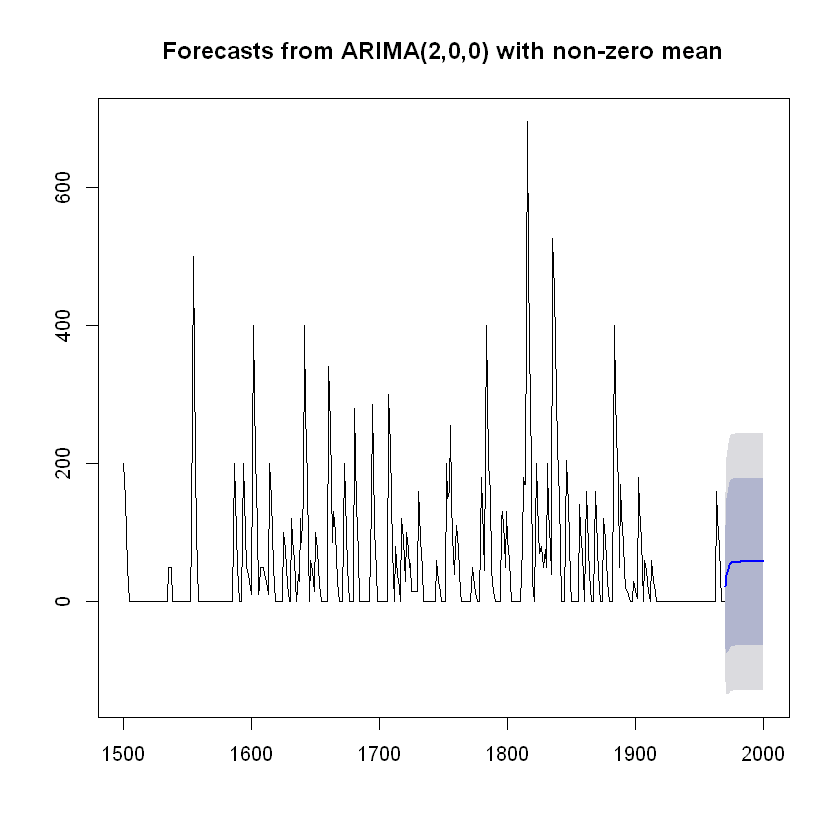

In [123]:
plot.forecast(volcanodustforecast)

En este caso especifico, la banda para los valores negativos no tiene sentido, pero el modelo la estima por defecto.

Luego, procedemos a verificar los errores del pronostico:


	Box-Ljung test

data:  volcanodustforecast$residuals
X-squared = 24.364, df = 20, p-value = 0.2268


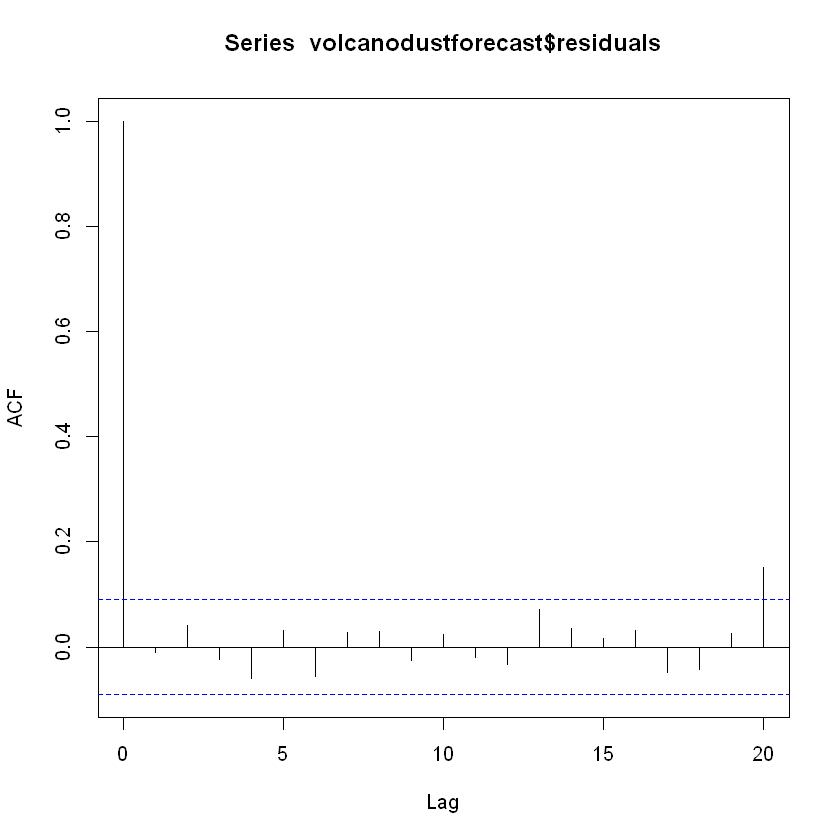

In [125]:
acf(volcanodustforecast$residuals, lag.max = 20)
Box.test(volcanodustforecast$residuals,lag = 20,type = "Ljung-Box")

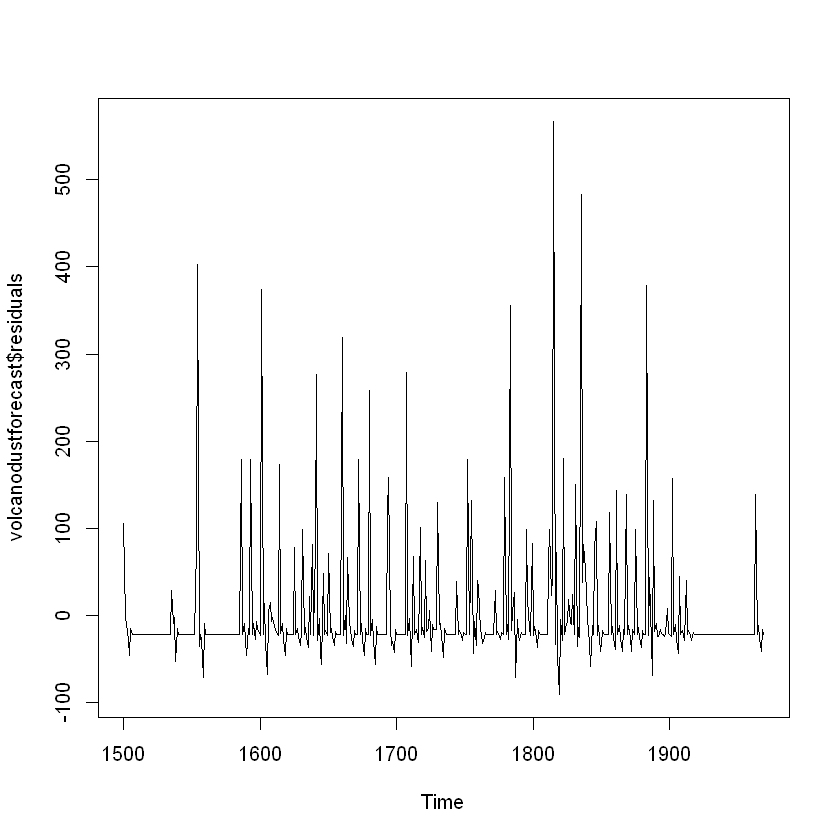

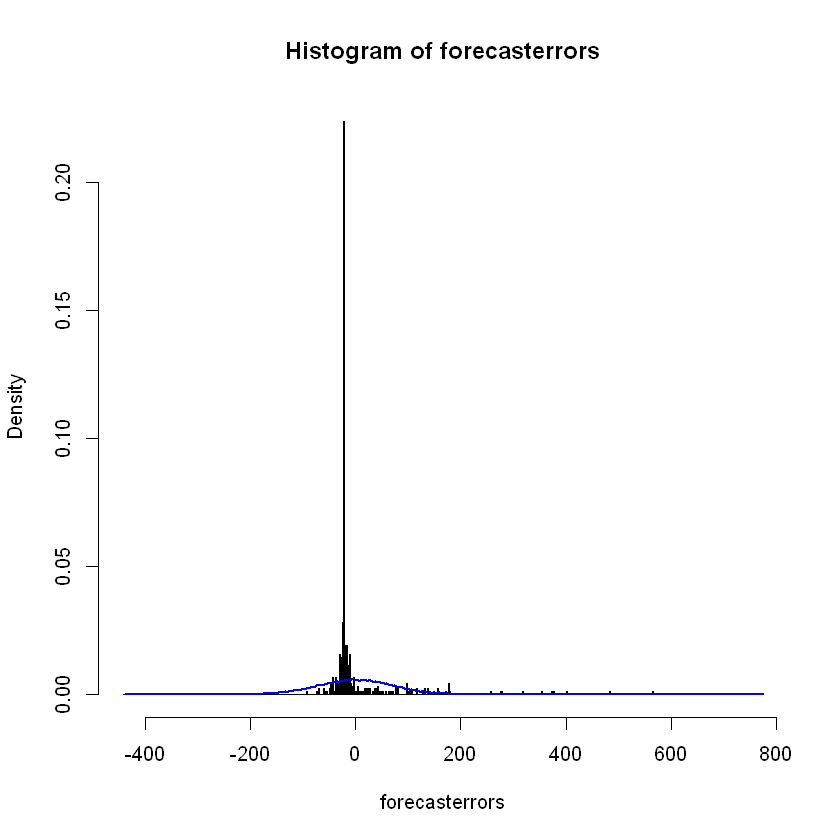

In [126]:
plot.ts(volcanodustforecast$residuals)
plotForecastErrors(volcanodustforecast$residuals)

Por la primera grafica, se puede ver que la media de los errores no es cero

In [127]:
mean(volcanodustforecast$residuals)

[1] -0.2205417

La distribucion de los errores muestra que hay una asimetria hacia la derecha comparado con una curva normal. Por lo tanto no podemos concluir que los errores se distribuyen normalmente. Por lo tanto el modelo ARMA(2,0,0) no es el mejor modelo y puede ser mejorado